In [1]:
# read two data files
# 1. tmdb
import pandas as pd
import numpy as np
#from surprise import Reader, Dataset, SVD
#from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import  Input, dot, concatenate
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import tensorflow as tf


#from keras.layers import Embedding, Reshape, Merge
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint



In [56]:
movies = pd.read_csv('datasets/ml-25m/movies.csv')
#titles = ['movie_ratings','movie_ids','user_ids','Timestamp']
ratings = pd.read_csv('datasets/ml-25m/ratings_small.csv')

In [11]:
# check data
ratings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [12]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [13]:
ratings.shape

(100004, 4)

In [14]:
movies.shape

(62423, 3)

In [16]:
# Join two dataset based on id (movie_id)
ratings.columns = ['userId','movieId','rating','timestamp']
df = movies.merge(ratings, on='movieId')

In [20]:
# check joined dataset

df.head(5)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       7     3.0   851866703  
1       9     4.0   938629179  
2      13     5.0  1331380058  
3      15     2.0   997938310  
4      19     3.0   855190091

In [70]:
# drop unnecessary columns

df = df.drop(['budget', 'homepage',
              'original_title', 'production_companies',
              'release_date', 'revenue', 'runtime',
              'spoken_languages', 'status', 'tagline','tittle'], axis=1)

In [21]:
# rename columns

df.columns = ['movieId', 'title', 'genres',
              'userId', 'rating',
              'timestamp']

In [22]:
# check data after removing unnecessary columns
df.head(1)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating  timestamp  
0       7     3.0  851866703

In [23]:
# Check for null values
df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [27]:
# get user ids and define encoding and decoding mapping
user_ids = ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}



In [28]:
# get movie ids and define encoding and decoding mapping
movie_ids = ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [29]:
# assign encoded user id and movie id inside the dataframe
ratings["user"] = ratings["userId"].map(user2user_encoded)
ratings["movie"] = ratings["movieId"].map(movie2movie_encoded)

In [30]:
# calculate total user and movie count

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

In [31]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

In [32]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 671, Number of Movies: 9066, Min rating: 0.5, Max rating: 5.0


In [33]:
movie_lens_ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [34]:
movie_lens_ratings = movie_lens_ratings.sample(frac=1, random_state=42)
x = movie_lens_ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = movie_lens_ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [35]:
# test and train data split
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, random_state = 42)


print("Data Shape: {}".format(df.shape))
print("Train Shape: {}".format(train_x.shape))
print("Test Shape: {}".format(test_x.shape))

train_x.shape

Data Shape: (99561, 6)
Train Shape: (75003, 2)
Test Shape: (25001, 2)


(75003, 2)

In [38]:
# map movie ids to a list of integers from 0 to 9723
uniqueIds = ratings.movieId.unique()
print(uniqueIds)

[  31 1029 1061 ...  129 4736 6425]


In [39]:
forwards = {}
backwards = {}
for x in range(num_movies):
    forwards.update({uniqueIds[x]: x})
    backwards.update({x: uniqueIds[x]})

In [40]:
for j in range(len(ratings)):
    ratings.iloc[j, 1] = forwards[ratings.iloc[j, 1]]

ratings.head()

userId  movieId  rating   timestamp  user  movie
0       1        0     2.5  1260759144     0      0
1       1        1     3.0  1260759179     0      1
2       1        2     3.0  1260759182     0      2
3       1        3     2.0  1260759185     0      3
4       1        4     4.0  1260759205     0      4

In [41]:
train, test = train_test_split(ratings, test_size=0.2, random_state=6)

In [42]:
# creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(num_movies + 1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)
# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(num_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = Concatenate()([movie_vec, user_vec])
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

In [43]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


In [44]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate, Embedding, Input, Dropout, Dot, Flatten, BatchNormalization

EMBEDDING_SIZE = 50


a = Input(shape=[2])
# b = Input(shape=[])


user_embedding = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )(a[:,0])

movie_embedding = layers.Embedding(
            num_movies,
            EMBEDDING_SIZE,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )(a[:,1])

dot = Dot(axes=1)([user_embedding, movie_embedding])

flatten_user = Flatten()(user_embedding)

flatten_movie = Flatten()(movie_embedding)

concat = Concatenate(axis=1)([flatten_user, flatten_movie])


dense_1 = Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5,l2=1e-6))(concat)

drop_1 = Dropout(0.5)(dense_1)

batch_norm_1 = BatchNormalization()

dense_2 = Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l2(1e-5))(drop_1)

drop_2 = Dropout(0.5)(dense_2)

batch_norm_2 = BatchNormalization()

dense_3 = Dense(16, activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l2(1e-5))(drop_2)

dense_4 = Dense(8, activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l2(1e-5))(dense_3)

concat_2 = Concatenate(axis=1)([dense_4, dot])

dense_sigmoid = Dense(1, activation='sigmoid', use_bias=True)(concat_2)

model = Model(inputs = [a], outputs = [dense_sigmoid])

# model.add(Concatenate(axis=1)([user_embedding, movie_embedding]))

model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])

history = model.fit(
    # x=[x_train[:,0], x_train[:,1]],
    x=x_val,
    y=y_val,
    batch_size=512,
    epochs=50,
    verbose=1,
    validation_data=(x_train, y_train),
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None,)             0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

Epoch 28/50
21/21 [==============================] - 1s 41ms/step - loss: 0.5902 - acc: 0.1537 - val_loss: 0.6150 - val_acc: 0.1518
Epoch 29/50
21/21 [==============================] - 1s 38ms/step - loss: 0.5874 - acc: 0.1547 - val_loss: 0.6154 - val_acc: 0.1518
Epoch 30/50
21/21 [==============================] - 1s 58ms/step - loss: 0.5855 - acc: 0.1547 - val_loss: 0.6159 - val_acc: 0.1516
Epoch 31/50
21/21 [==============================] - 1s 60ms/step - loss: 0.5840 - acc: 0.1562 - val_loss: 0.6163 - val_acc: 0.1513
Epoch 32/50
21/21 [==============================] - 1s 51ms/step - loss: 0.5820 - acc: 0.1574 - val_loss: 0.6171 - val_acc: 0.1511
Epoch 33/50
21/21 [==============================] - 1s 49ms/step - loss: 0.5808 - acc: 0.1575 - val_loss: 0.6177 - val_acc: 0.1508
Epoch 34/50
21/21 [==============================] - 1s 49ms/step - loss: 0.5795 - acc: 0.1585 - val_loss: 0.6181 - val_acc: 0.1505
Epoch 35/50
21/21 [==============================] - 1s 40ms/step - loss: 0.

In [46]:
x_train.shape

(89604, 2)

In [47]:
x_val.shape

(10400, 2)

Text(0, 0.5, 'Training Error')

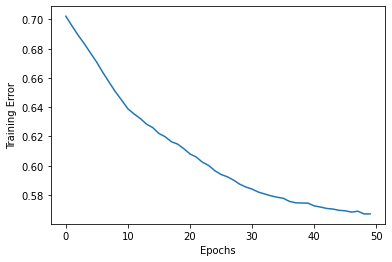

In [48]:
model.save('datasets/model/NN_model.hdf5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

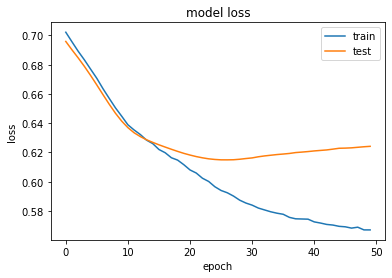

In [49]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()


In [50]:
loaded_our_model = load_model('datasets/model/NN_model.hdf5', custom_objects={'leaky_relu': tf.nn.leaky_relu})
print('Our model loaded')

Our model loaded


In [54]:
import pandas as pd

print(ratings.userId.sample(10).iloc[0])
user_id = ratings.userId.sample(1).iloc[0]
movies_watched_by_user = ratings[ratings.userId == user_id]
movies_not_watched = movies[
    ~movies["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)


590


In [55]:
ratings_values = loaded_our_model.predict(user_movie_array).flatten()
top_ratings_indices = ratings_values.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movies[movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)



237/237 [==============================] - 0s 2ms/step
Showing recommendations for user: 15
Movies with high ratings from user
--------------------------------
Clear and Present Danger (1994) : Action|Crime|Drama|Thriller
8 Seconds (1994) : Drama
House Party 3 (1994) : Comedy
Maltese Falcon, The (1941) : Film-Noir|Mystery
Christmas Carol, A (1938) : Children|Drama|Fantasy
--------------------------------
Top 10 movie recommendations
--------------------------------
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Swing Kids (1993) : Drama|War
Endurance (1999) : Documentary|Drama
Crimes and Misdemeanors (1989) : Comedy|Crime|Drama
Prick Up Your Ears (1987) : Comedy|Drama
Love and Death (1975) : Comedy
Wall Street (1987) : Drama
The Butterfly Effect (2004) : Drama|Sci-Fi|Thriller
Thank You for Smoking (2006) : Comedy|Drama
Boy (2010) : Comedy|Drama
